<a href="https://colab.research.google.com/github/Ly-xinhgai/recommendation-system-using-knn/blob/main/recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load thư viện và connect gg drive**

In [ ]:
#Khởi tạo thư viện
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
from scipy.spatial import distance
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.neighbors import BallTree, KDTree
import random
import time



# Tắt tất cả các cảnh báo
warnings.filterwarnings('ignore')

In [ ]:
# Kết nối Google Drive với Colab
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import time

def measure_time(task_name, func, *args, **kwargs):
    start_time = time.time()  # Bắt đầu đo thời gian
    result = func(*args, **kwargs)  # Thực thi đoạn code
    end_time = time.time()  # Kết thúc đo thời gian
    print(f"Thời gian chạy cho {task_name}: {end_time - start_time:.2f} giây")
    return result  # Trả về kết quả


# **Chuẩn bị dữ liệu**

In [ ]:
# Đọc dữ liệu anime
data =  pd.read_csv('/content/drive/MyDrive/doan2/data/anime.csv')
rating_data = pd.read_csv('/content/drive/MyDrive/doan2/data/rating.csv')


# **Chi tiết Tập Dữ Liệu**


1. anime_data:

* anime_id - id duy nhất của myanimelist.net xác định một anime.
* name - tên đầy đủ của anime.
* genre - danh sách các thể loại được phân cách bởi dấu phẩy cho anime này.
* type - phim, TV, OVA, v.v.
* episodes - số lượng tập trong chương trình này. (1 nếu là phim).
* rating - điểm trung bình trên 10 cho anime này.
* members - số lượng thành viên trong cộng đồng tham gia vào "nhóm" của anime này.

In [ ]:
# Hiển thị kích thước dữ liệu
print("Kích thước anime_data:", data.shape)
data.head()

Kích thước anime_data: (12294, 7)


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


# **Xử Lý Giá Trị Thiếu**

In [ ]:
#Xử Lý Giá Trị Thiếu
data['type'].unique()
data[data['episodes'] == 'Unknown']

,anime_id,name,genre,type,episodes,rating,members
74,21,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",TV,Unknown,8.58,504862
252,235,Detective Conan,"Adventure, Comedy, Mystery, Police, Shounen",TV,Unknown,8.25,114702
615,1735,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,Unknown,7.94,533578
991,966,Crayon Shin-chan,"Comedy, Ecchi, Kids, School, Shounen, Slice of...",TV,Unknown,7.73,26267
1021,33157,Tanaka-kun wa Itsumo Kedaruge Specials,"Comedy, School, Slice of Life",Special,Unknown,7.72,5400
...,...,...,...,...,...,...,...
12265,34361,Kyonyuu Reijou MC Gakuen,Hentai,OVA,Unknown,NaN,205
12274,34492,Nuki Doki! Tenshi to Akuma no Sakusei Battle -...,Hentai,OVA,Unknown,NaN,392
12280,34312,Saimin Class,Hentai,OVA,Unknown,NaN,240
12282,34388,Shikkoku no Shaga The Animation,Hentai,OVA,Unknown,NaN,195


* `data['type'].unique()` liệt kê các loại anime khác nhau.
* `data[data['episodes'] == 'Unknown']` lọc những anime có số tập là `'Unknown'`.

**Xử Lý Giá Trị `'Unknown'` cho Số Tập**

In [ ]:
data.loc[(data['type'] == 'TV') & (data['episodes'] == 'Unknown'),"episodes"] = 1
data.loc[(data['type'] == 'OVA') & (data['episodes'] == 'Unknown'),"episodes"] = 1
data.loc[(data['type'] == 'Movie') & (data['episodes'] == 'Unknown'),"episodes"] = 1

* Với các anime có loại `TV`, `OVA`, hoặc `Movie` mà số tập là `'Unknown'`, gán số tập là 1.

In [ ]:
known_animes = {"Naruto Shippuuden":500, "One Piece":784,"Detective Conan":854, "Dragon Ball Super":86,
                "Crayon Shin chan":942, "Yu Gi Oh Arc V":148,"Shingeki no Kyojin Season 2":25,
                "Boku no Hero Academia 2nd Season":25,"Little Witch Academia TV":25}
for key,values in known_animes.items():
    data.loc[data['name'] == key, "episodes"] = values

Gán số tập chính xác cho một số anime nổi tiếng trong `known_animes`.

In [ ]:
data['episodes'] = data['episodes'].apply(lambda x:np.nan if x=="Unknown" else x)
data['episodes'].fillna(data['episodes'].median(),inplace=True)

* Chuyển các giá trị `'Unknown'` của `episodes` thành `NaN`, sau đó điền giá trị `NaN` bằng giá trị trung vị.

**Xử Lý Giá Trị Thiếu của `rating`**

In [ ]:
data['rating'].fillna(data['rating'].mean(),inplace=True)

* Điền các giá trị thiếu trong `rating` bằng trung bình của các giá trị hiện có.

# **Biến Đổi và Chuẩn Hóa Dữ Liệu**

In [ ]:
data['genre'].fillna('Unknown', inplace=True)
data.dropna(subset=['type'], inplace=True)

In [ ]:
pd.get_dummies(data[['type']]).head()
data['members'] = data['members'].astype(float)

* Mã hóa cột `type` bằng `pd.get_dummies()` để chuyển dữ liệu dạng phân loại sang dạng số.
* `members` được chuyển sang kiểu `float` để dễ dàng tính toán.

In [ ]:
anime_features = pd.concat([data["genre"].str.get_dummies(sep=","),
                            pd.get_dummies(data[["type"]]),
                            data[["rating"]],data[["members"]],data["episodes"]],axis=1)

* `anime_features` bao gồm các cột đã mã hóa của `genre`, `type`, và các cột `rating`, `members`, `episodes`.

In [ ]:
data["name"] = data["name"].map(lambda name:re.sub('[^A-Za-z0-9]+', " ", name))

* Loại bỏ các ký tự không phải chữ cái và số trong tên anime.

**Chuẩn Hóa Dữ Liệu**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
anime_features = mms.fit_transform(anime_features)

* Dữ liệu trong `anime_features` được chuẩn hóa về khoảng từ 0 đến 1 bằng `MinMaxScaler` để đảm bảo các đặc trưng ở cùng một thang đo.


# **Tạo Mô Hình KNN**

In [ ]:
# Tạo Mô Hình KNN với tham số distance
class KNearestNeighbours(BaseEstimator, RegressorMixin):
    def __init__(self, k=3, distance='euclidean'):
        self.k = k
        self.distance = distance
        self.tree = None
        self.target = None

    def fit(self, data, target):
        self.data = data
        self.target = np.array(target)  # Chuyển đổi thành NumPy array
        self.tree = BallTree(data, metric=self.distance)  # Sử dụng metric cho khoảng cách

    def predict(self, test_data):
        dist, indices = self.tree.query(test_data, k=self.k)  # Tìm k điểm gần nhất
        k_nearest_values = self.target[indices]  # Lấy nhãn của k điểm gần nhất
        return np.mean(k_nearest_values, axis=1)  # Dự đoán bằng cách lấy trung bình

    def score(self, X_test, y_test):
        predictions = self.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        return -mse


In [ ]:
# Giả sử anime_features chứa các đặc trưng bạn muốn sử dụng
X = anime_features  # các đặc trưng
y = data['rating']  # nhãn (điểm đánh giá anime)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Kiểm tra kích thước của các tập dữ liệu
print("Kích thước tập huấn luyện:", X_train.shape, y_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape, y_test.shape)

Kích thước tập huấn luyện: (9815, 92) (9815,)
Kích thước tập kiểm tra: (2454, 92) (2454,)


In [ ]:

# Chọn ngẫu nhiên 50% giá trị K từ 1 đến 20, sắp xếp từ bé đến lớn
random.seed(42)
k_values = sorted(random.sample(range(3, 21), k=10))
print("Giá trị k:", k_values)

# Thiết lập các metric khoảng cách phù hợp với BallTree
param_grid = {
    'k': k_values,
    'distance': ['euclidean', 'manhattan']
}

# Khởi tạo GridSearchCV để tìm kiếm giá trị K và khoảng cách tốt nhất
grid_search = GridSearchCV(KNearestNeighbours(), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=3)

# Thực hiện tìm kiếm K và khoảng cách tốt nhất
print("Bắt đầu tìm kiếm giá trị K và khoảng cách tốt nhất...")
grid_search.fit(X_train, y_train)

Giá trị k: [3, 4, 5, 6, 11, 13, 14, 17, 18, 20]
Bắt đầu tìm kiếm giá trị K và khoảng cách tốt nhất...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ..........distance=euclidean, k=3;, score=-0.254 total time=   3.0s
[CV 2/5] END ..........distance=euclidean, k=3;, score=-0.269 total time=   1.9s
[CV 3/5] END ..........distance=euclidean, k=3;, score=-0.312 total time=   2.3s
[CV 4/5] END ..........distance=euclidean, k=3;, score=-0.289 total time=   2.0s
[CV 5/5] END ..........distance=euclidean, k=3;, score=-0.280 total time=   1.9s
[CV 1/5] END ..........distance=euclidean, k=4;, score=-0.244 total time=   3.4s
[CV 2/5] END ..........distance=euclidean, k=4;, score=-0.271 total time=   2.9s
[CV 3/5] END ..........distance=euclidean, k=4;, score=-0.301 total time=   1.9s
[CV 4/5] END ..........distance=euclidean, k=4;, score=-0.298 total time=   1.9s
[CV 5/5] END ..........distance=euclidean, k=4;, score=-0.280 total time=   2.8s
[CV 1/5] END ..........dis

GridSearchCV(cv=5, estimator=KNearestNeighbours(),
             param_grid={'distance': ['euclidean', 'manhattan'],
                         'k': [3, 4, 5, 6, 11, 13, 14, 17, 18, 20]},
             scoring='neg_mean_squared_error', verbose=3)

Best k: 4, Best distance: euclidean, with Mean Squared Error: 0.27879423635695366
Đánh giá mô hình tốt nhất trên tập kiểm tra...
Test Mean Squared Error: 0.24201225871110302
Vẽ biểu đồ phụ thuộc giữa K và MSE...


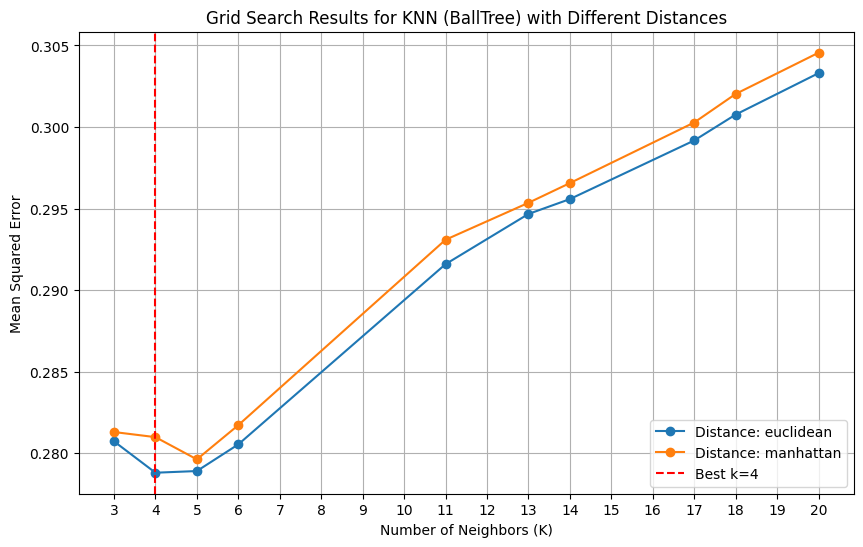

In [ ]:

# Log kết quả tốt nhất
best_k = grid_search.best_params_['k']
best_distance = grid_search.best_params_['distance']
best_mse = -grid_search.best_score_  # Đổi dấu MSE về giá trị dương
print(f"Best k: {best_k}, Best distance: {best_distance}, with Mean Squared Error: {best_mse}")

# Đánh giá trên tập kiểm tra
print("Đánh giá mô hình tốt nhất trên tập kiểm tra...")
y_pred = grid_search.best_estimator_.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error: {test_mse}")

# Biểu đồ biểu diễn K và MSE
print("Vẽ biểu đồ phụ thuộc giữa K và MSE...")
results = grid_search.cv_results_
distances = ['euclidean', 'manhattan']

plt.figure(figsize=(10, 6))
for distance in distances:
    mask = results['param_distance'] == distance
    k_vals = results['param_k'][mask]
    mse_means = -results['mean_test_score'][mask]
    plt.plot(k_vals, mse_means, marker='o', label=f'Distance: {distance}')

# Thêm đường thẳng cho giá trị k tốt nhất
plt.axvline(best_k, color='r', linestyle='--', label=f'Best k={best_k}')

# Thiết lập trục x với các giá trị k là số nguyên
plt.xticks(range(min(k_values), max(k_values) + 1))  # Thay đổi ở đây

plt.title('Grid Search Results for KNN (BallTree) with Different Distances')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()



* Sử dụng `NearestNeighbors` với thuật toán `ball_tree` để tìm k-1 anime tương tự nhất cho mỗi anime (bao gồm cả chính nó).
* `kneighbors` trả về `distances` (khoảng cách tới các hàng xóm) và `indices` (chỉ số của các hàng xóm trong `anime_features`).

# **Xây Dựng Các Hàm Gợi Ý**

In [ ]:
def run_experiments():
  # Khởi tạo mô hình KNN với giá trị k đã tìm thấy từ grid search
  knn_model = KNearestNeighbours(k=4, distance='euclidean')

  # Huấn luyện mô hình trên toàn bộ tập dữ liệu
  knn_model.fit(anime_features, data['rating'])

  # Tìm kiếm k hàng xóm gần nhất cho tất cả các anime trong anime_features
  distances, indices = knn_model.tree.query(anime_features, k=4)  # Sử dụng k tốt nhất tìm được từ grid search

  # **Hàm Gợi Ý Phim**
  def recommend_anime_for_user_with_knn(user_id, num_recommendations=10):
      # Lấy danh sách các phim mà người dùng đã đánh giá
      user_rated_animes = rating_data[rating_data['user_id'] == user_id]
      if user_rated_animes.empty:
          print(f"Người dùng {user_id} không có đánh giá nào.")
          return []  # Trả về danh sách rỗng nếu không có đánh giá

      # Chỉ lấy các phim mà người dùng đánh giá cao (ví dụ: điểm >= 8)
      liked_animes = user_rated_animes[user_rated_animes['rating'] >= 8]['anime_id']

      if liked_animes.empty:
          print(f"Người dùng {user_id} không có phim nào đánh giá cao.")
          return []  # Trả về danh sách rỗng nếu không có phim đánh giá cao

      # Tìm các phim tương tự với các phim mà người dùng thích
      recommended_animes = {}
      for anime_id in liked_animes:
          # Lấy index của phim trong dữ liệu
          anime_index = data[data['anime_id'] == anime_id].index[0]

          # Tìm k phim tương tự (bao gồm khoảng cách)
          similar_anime_indices = indices[anime_index][1:]  # Bỏ qua chính nó
          similar_anime_distances = distances[anime_index][1:]

          for idx, distance in zip(similar_anime_indices, similar_anime_distances):
              if idx not in recommended_animes:
                  recommended_animes[idx] = {"distance": [], "ratings": []}
              recommended_animes[idx]["distance"].append(distance)
              # Thay đổi 'average_rating' thành 'rating'
              recommended_animes[idx]["ratings"].append(data.loc[anime_index, "rating"])

      # Tính điểm dự đoán cho từng anime được gợi ý
      detailed_recommendations = []
      for idx, info in recommended_animes.items():
          # Trọng số: 1 / khoảng cách
          weights = [1 / d if d > 0 else 1 for d in info["distance"]]
          weighted_average_rating = sum(r * w for r, w in zip(info["ratings"], weights)) / sum(weights)

          # Lấy thông tin phim
          anime_row = data.loc[idx]
          detailed_recommendations.append({
              "anime_id": anime_row["anime_id"],
              "name": anime_row["name"],
              "genre": anime_row["genre"],
              # Thay đổi 'average_rating' thành 'rating'
              "average_rating": anime_row["rating"],
              "members": anime_row["members"],
              "predicted_score": weighted_average_rating
          })

      # Sắp xếp danh sách theo điểm dự đoán
      detailed_recommendations.sort(key=lambda x: x["predicted_score"], reverse=True)

      # Lấy top num_recommendations
      top_recommendations = detailed_recommendations[:num_recommendations]

      # In ra danh sách gợi ý
      print(f"\n{'='*60}")
      print(f"Gợi ý phim cho người dùng {user_id}:")
      print(f"{'ID':<10} {'Tên phim':<30} {'Thể loại':<20} {'Điểm TB':<10} {'Dự đoán':<10} {'Thành viên':<10}")
      print(f"{'-'*60}")
      for rec in top_recommendations:
          print(f"{rec['anime_id']:<10} {rec['name'][:30]:<30} {rec['genre'][:20]:<20} "
                f"{rec['average_rating']:<10.2f} {rec['predicted_score']:<10.2f} {rec['members']:<10}")
      print(f"{'='*60}\n")
      return top_recommendations  # Trả về danh sách gợi ý chi tiết



  user_id_to_recommend = 3569
  recommend_anime_for_user_with_knn(user_id_to_recommend, num_recommendations=10)


measure_time("Thời gian chạy mô hình KNN", run_experiments)


Gợi ý phim cho người dùng 3569:
ID         Tên phim                       Thể loại             Điểm TB    Dự đoán    Thành viên
------------------------------------------------------------
121        Fullmetal Alchemist            Action, Adventure, C 8.33       9.26       600384.0  
14513      Magi The Labyrinth of Magic    Action, Adventure, F 8.24       9.26       317513.0  
18115      Magi The Kingdom of Magic      Action, Adventure, F 8.50       9.26       245026.0  
10348      Fireball Charming              Sci-Fi               6.94       9.17       5640.0    
11213      Hoshi no Ko Poron              Sci-Fi               6.76       9.17       117.0     
33988      Demi chan wa Kataritai         Comedy, Fantasy, Sch 6.47       9.17       6252.0    
28805      Bakemono no Ko                 Adventure, Supernatu 8.58       8.93       80825.0   
2141       Oseam                          Adventure, Drama     7.43       8.93       3648.0    
5084       Mai Mai Shinko to Sennen no Ma 